In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import norm
import datetime

rng = np.random.default_rng(seed=42)

In [2]:
# === Historical Parcel Volume Data (Early and Late Years) from Statista and BIEK ===

# --- Early historical data (2000–2013) ---
data_early = {
    "Year": np.array([
        2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012, 2013
    ]),
    
    "Parcel_Volume": np.array([
        1.701, 1.730, 1.765, 1.802, 1.849, 1.952, 2.150, 2.235,
        2.221, 2.179, 2.333, 2.475, 2.550, 2.625
    ])
}

# --- More recent data (2014–2028, including some estimated values from statista source) ---
data_late = {
    "Year": np.array([
        2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
        2022, 2023, 2024, 2025, 2026, 2027, 2028
    ]),
    
    "Parcel_Volume": np.array([
        2.780, 2.950, 3.160, 3.350, 3.520, 3.650, 4.050, 4.510,
        4.150, 4.175, 4.200, 4.300, 4.420, 4.550, 4.680
    ])
}


# === Convert to Pandas DataFrames ===

# Create DataFrame from early data
df_early = pd.DataFrame(data_early)

# Create DataFrame from recent/late data
df_late = pd.DataFrame(data_late)


# === Merge Both DataFrames ===

# Combine early and late data into a single DataFrame
df_parcel_volumes = pd.concat([df_early, df_late], ignore_index=True)


# === Separate Estimated Future Values (post-2023) ===

# Extract only the future years (estimated projections)
df_parcel_volumes_estimated = df_parcel_volumes[df_parcel_volumes["Year"] > 2023]
df_parcel_volumes_log = df_parcel_volumes[df_parcel_volumes.Year > 2005]

# (Optional) Keep only data up to 2023 — uncomment if needed
# df_parcel_volumes = df_parcel_volumes[df_parcel_volumes["Year"] <= 2023]


# === Data Cleanup: Remove Outlier or Anomaly ===
# Exclude the year 2021 from analysis (e.g., due to anomaly like COVID-related spike)
df_parcel_volumes_filtered = df_parcel_volumes[df_parcel_volumes["Year"] != 2021]
df_parcel_volumes


,Year,Parcel_Volume
0,2000,1.701
1,2001,1.730
2,2002,1.765
3,2003,1.802
4,2004,1.849
5,2005,1.952
6,2006,2.150
7,2007,2.235
8,2008,2.221
9,2009,2.179


In [ ]:
# === Exponential Growth Model ===

def exponential_function(x, a, b):
    """
    Exponential function to model parcel volume growth.

    Inputs:
    -------
    x : array-like or float
        Independent variable (e.g., years).
    a : float
        Scaling factor — the estimated volume at the reference year (2028).
    b : float
        Growth rate. Positive values indicate growth, negative values indicate decay.

    Returns:
    --------
    float or array-like
        Predicted value(s) of the exponential function at x.
    
    Notes:
    ------
    The expression (x - 2028) anchors the model to year 2028,
    which stabilizes the curve-fitting numerics and makes parameter 'a'
    represent the value in 2028 directly.
    """
    return a * np.exp(b * (x - 2028))


# === Logistic (S-Curve) Model ===

def logistic_function(x, a, b, c):
    """
    Logistic function (sigmoid curve) to model saturating growth.

    Inputs:
    -------
    x : array-like or float
        Independent variable (e.g., years).
    a : float
        Maximum (asymptotic) value the function approaches.
    b : float
        Growth rate — how quickly the curve rises.
    c : float
        Inflection point — the year where the curve changes from accelerating to decelerating.

    Returns:
    --------
    float or array-like
        Predicted value(s) of the logistic function at x.
    """
    return a / (1 + np.exp(-b * (x - c)))


# === Error Metrics ===

def rmse(y_true, y_pred):
    """
    Root Mean Squared Error (RMSE).

    Inputs:
    -------
    y_true : array-like
        True/observed values.
    y_pred : array-like
        Predicted values from the model.

    Returns:
    --------
    float
        Root mean squared error, penalizing larger errors more strongly.
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mae(y_true, y_pred):
    """
    Mean Absolute Error (MAE).

    Inputs:
    -------
    y_true : array-like
        True/observed values.
    y_pred : array-like
        Predicted values from the model.

    Returns:
    --------
    float
        Mean absolute error — average of the absolute differences between predicted and true values.
    """
    return mean_absolute_error(y_true, y_pred)


# === AIC Calculation ===

def calculate_aic(y_true, y_pred, num_params):
    """
    Compute Akaike Information Criterion (AIC) for model evaluation.

    Inputs:
    -------
    y_true : array-like
        True/observed data values.
    y_pred : array-like
        Predicted values from the model.
    num_params : int
        Number of parameters in the model (used for penalizing model complexity).

    Returns:
    --------
    float
        AIC score — lower values indicate a better balance between model fit and complexity.

    Formula:
    --------
    AIC = n * ln(RSS/n) + 2 * k
      where:
        n   = number of observations
        RSS = residual sum of squares = sum((y_true - y_pred)^2)
        k   = number of model parameters
    """
    residuals = y_true - y_pred
    n = len(y_true)
    rss = np.sum(residuals**2)
    return n * np.log(rss / n) + 2 * num_params

def compute_confidence_interval(model_func, x_vals, popt, pcov, confidence=0.95):
    """
    Computes the confidence interval of a model prediction using the Jacobian and parameter covariance matrix.

    Parameters:
    -----------
    model_func : callable
        The fitted model function.
    x_vals : array-like
        X values for prediction.
    popt : array
        Optimized model parameters.
    pcov : 2D array
        Covariance matrix from curve_fit.
    confidence : float
        Confidence level (default: 95%).

    Returns:
    --------
    y_fit : np.array
        Predicted values from the model.
    ci_lower : np.array
        Lower bound of the confidence interval.
    ci_upper : np.array
        Upper bound of the confidence interval.
    """
   

    alpha = 1.0 - confidence
    z = norm.ppf(1.0 - alpha / 2.0)

    y_fit = model_func(x_vals, *popt)

    # Numerical approximation of Jacobian (partial derivatives)
    eps = np.sqrt(np.finfo(float).eps)
    J = np.array([
        (model_func(x_vals, *(popt + eps * (np.arange(len(popt)) == i))) - y_fit) / eps
        for i in range(len(popt))
    ]).T

    var_pred = np.sum(J @ pcov * J, axis=1)
    sigma_pred = np.sqrt(var_pred)

    ci_lower = y_fit - z * sigma_pred
    ci_upper = y_fit + z * sigma_pred

    return y_fit, ci_lower, ci_upper

# Linear model confidence interval estimation
def compute_linear_ci(model, X, confidence=0.95):
    from scipy.stats import t

    y_pred = model.predict(X)
    n = len(X)
    dof = n - 2
    t_val = t.ppf(1 - (1 - confidence) / 2., dof)

    x_mean = np.mean(X)
    se = np.sqrt(np.sum((y_pred - np.mean(y_pred)) ** 2) / (n - 2))
    conf_interval = t_val * se * np.sqrt(1/n + (X - x_mean)**2 / np.sum((X - x_mean)**2))

    ci_lower = y_pred - conf_interval.flatten()
    ci_upper = y_pred + conf_interval.flatten()
    return y_pred, ci_lower, ci_upper

# === ADDITIONAL DATA: ISO WEEKS IN YEAR ===
# Function to calculate the number of ISO weeks in a given year 

def get_weeks_in_year(year):
    """
    Returns the number of ISO weeks in a given year (52 or 53).
    Uses Dec 28 to ensure it's part of the correct final ISO week.
    """
    year = int(year)  # Ensure it's an integer
    date = datetime.date(year, 12, 28)
    return date.isocalendar()[1]  # 52 or 53

# === LINEAR MODEL FITTING ===

# Prepare the feature matrix (X) for linear regression — years as independent variable
X_linear = df_parcel_volumes["Year"].values.reshape(-1, 1)  # Reshape to 2D for sklearn

# Instantiate and fit a linear regression model on all available data
model_linear = LinearRegression()
model_linear.fit(X_linear, df_parcel_volumes["Parcel_Volume"])

# Predict parcel volumes using the fitted linear model
y_pred_linear = model_linear.predict(X_linear)


# === LOGISTIC MODEL FITTING ===

# Fit a logistic (sigmoid) model to the data using non-linear least squares
# Initial parameter guess: a=10 (max value), b=0.1 (growth rate), c=2015 (midpoint year)

# We apply the logistic model only to data from the year > 2005  onward.
# Rationale:
# - Around 2005, a noticeable sharp increase in parcel volumes is observed.
# - This suggests the beginning of a saturation trend, which is well captured by the logistic function.
# - The logistic model is thus intended to reflect only the *flattening behavior* of this steep growth phase.
# - Earlier data points (2000-2005) are not included in the logistic fit to avoid skewing the model.

# === Logistic Model Fitting (with Covariance Matrix) ===
popt, pcov = curve_fit(
    logistic_function,
    df_parcel_volumes_log["Year"],
    df_parcel_volumes_log["Parcel_Volume"],
    p0=[10, 0.1, 2015]
)

# Predict values using the fitted logistic model
# Still predict over the full range
y_pred_logistic = logistic_function(df_parcel_volumes_log["Year"], *popt)


# === EXPONENTIAL MODEL FITTING ===

# Fit an exponential model to the data
# Initial guess: a=1 (scale), b=0.05 (growth rate)
# === Exponential Model Fitting (with Covariance Matrix) ===
exp_params, pcov_exp = curve_fit(
    exponential_function,
    df_parcel_volumes["Year"],
    df_parcel_volumes["Parcel_Volume"],
    p0=[1, 0.05]
)

# Predict values using the fitted exponential model
y_pred_exponential = exponential_function(df_parcel_volumes["Year"], *exp_params)

# === EVALUATE MODEL PERFORMANCE ===

# Create a DataFrame to compare model performance using RMSE, MAE, and AIC
metrics = pd.DataFrame({
    "Model": ["Linear", "Logistic", "Exponential"],

    "RMSE": [
        rmse(df_parcel_volumes["Parcel_Volume"], y_pred_linear),        # Root Mean Squared Error
        rmse(df_parcel_volumes_log["Parcel_Volume"], y_pred_logistic),
        rmse(df_parcel_volumes["Parcel_Volume"], y_pred_exponential),
    ],

    "MAE": [
        mae(df_parcel_volumes["Parcel_Volume"], y_pred_linear),         # Mean Absolute Error
        mae(df_parcel_volumes_log["Parcel_Volume"], y_pred_logistic),
        mae(df_parcel_volumes["Parcel_Volume"], y_pred_exponential),
    ],

    "AIC": [
        calculate_aic(df_parcel_volumes["Parcel_Volume"], y_pred_linear, 2),        # Linear model: 2 params
        calculate_aic(df_parcel_volumes_log["Parcel_Volume"], y_pred_logistic, 3),      # Logistic: 3 params
        calculate_aic(df_parcel_volumes["Parcel_Volume"], y_pred_exponential, 2),   # Exponential: 2 params
    ]
})


# === FORECASTING TO 2050 ===

# Create array of years for future forecasting (2000 to 2050)
years = np.arange(2000, 2051, 1)
X_future = years.reshape(-1, 1)  # Prepare shape for linear model input

# Predict future parcel volumes using each model
y_future_linear = model_linear.predict(X_future)
y_future_log = logistic_function(years, *popt)
y_future_exp = exponential_function(years, *exp_params)

# === Compute Confidence Intervals for Each Model Forecast ===

# --- Linear Regression Model Confidence Interval ---
# Uses analytical formula based on Student's t-distribution.
# Accounts for uncertainty in the regression line given the input years.
_, ci_lower_linear, ci_upper_linear = compute_linear_ci(model_linear, X_future)

# --- Logistic (Sigmoid) Model Confidence Interval ---
# Uses numerical approximation of the Jacobian and the covariance matrix
# returned by curve_fit to compute parameter uncertainty propagation.
_, ci_lower_logistic, ci_upper_logistic = compute_confidence_interval(
    logistic_function, years, popt, pcov
)


# --- Exponential Growth Model Confidence Interval ---
# Also uses the Jacobian method and curve_fit covariance matrix to estimate
# confidence bounds for the nonlinear exponential curve.
_, ci_lower_exp, ci_upper_exp = compute_confidence_interval(
    exponential_function, years, exp_params, pcov_exp
)

years_observed = df_parcel_volumes["Year"]
vol_observed = df_parcel_volumes["Parcel_Volume"]

# Extract subset for logistic (might be shorter range)
log_observed = df_parcel_volumes_log.set_index("Year")["Parcel_Volume"].reindex(years_observed).values


# === CONSOLIDATE FORECAST RESULTS ===

# Slice the future values from 2029 onward
future_mask = years >= 2029

# Build full merged forecast DataFrame
forecast_df = pd.DataFrame({
    "year": np.concatenate([years_observed, years[future_mask]]),

    "linear": np.concatenate([
        vol_observed,
        y_future_linear[future_mask]
    ]),
    "ci_lower_linear": np.concatenate([
        vol_observed,  
        ci_lower_linear[future_mask]
    ]),
    "ci_upper_linear": np.concatenate([
        vol_observed,
        ci_upper_linear[future_mask]
    ]),

    "logistic": np.concatenate([
        vol_observed,
        y_future_log[future_mask]
    ]),
    "ci_lower_logistic": np.concatenate([
        vol_observed,
        ci_lower_logistic[future_mask]
    ]),
    "ci_upper_logistic": np.concatenate([
        vol_observed,
        ci_upper_logistic[future_mask]
    ]),

    "exponential": np.concatenate([
        vol_observed,
        y_future_exp[future_mask]
    ]),
    "ci_lower_exponential": np.concatenate([
        vol_observed,
        ci_lower_exp[future_mask]
    ]),
    "ci_upper_exponential": np.concatenate([
        vol_observed,
        ci_upper_exp[future_mask]
    ])
})

forecast_df["type"] = np.where(forecast_df["year"] < 2029, "Observed", "Forecast")

# Apply function to each forecast year
forecast_df["weeks_in_year"] = forecast_df["year"].apply(get_weeks_in_year)

In [39]:
# === Create DataFrame with model-only predictions ===
model_predictions_df = pd.DataFrame({
    "year": years,  # years = np.arange(2000, 2051)
    "linear_model_predicted": y_future_linear,
    "logistic_model_predicted": y_future_log,
    "exponential_model_predicted": y_future_exp
})

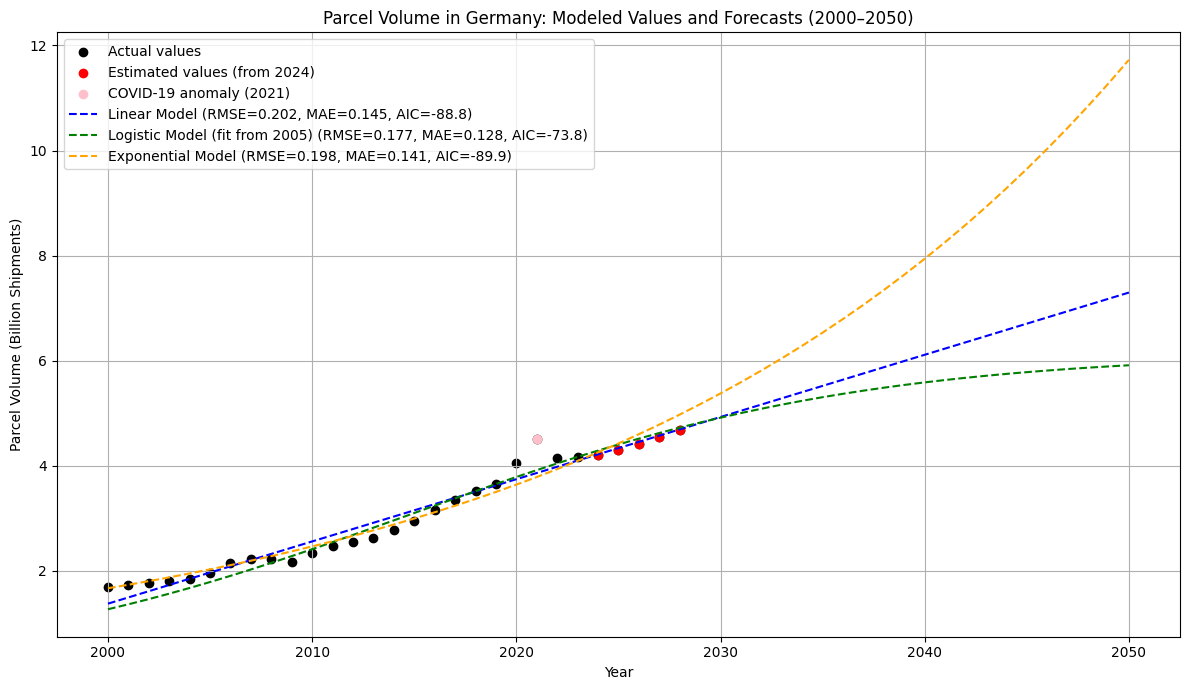

In [12]:
# === Plot Parcel Volume Forecast with Model Comparisons ===

# Create a new figure with specified size
plt.figure(figsize=(12, 7))

# --- Actual Observed Data ---
plt.scatter(
    df_parcel_volumes["Year"],
    df_parcel_volumes["Parcel_Volume"],
    color="black",
    label="Actual values"
)

# --- Estimated Future Data (from 2024 onward) ---
plt.scatter(
    df_parcel_volumes_estimated["Year"],
    df_parcel_volumes_estimated["Parcel_Volume"],
    color="red",
    label="Estimated values (from 2024)"
)

# --- Special Marker for 2021 (COVID-related anomaly) ---
plt.scatter(
    df_parcel_volumes[df_parcel_volumes.Year == 2021]["Year"],
    df_parcel_volumes[df_parcel_volumes.Year == 2021]["Parcel_Volume"],
    color="pink",
    label="COVID-19 anomaly (2021)"
)


# === Forecast Lines: Linear, Logistic, Exponential ===
# These lines show predictions from 2014 to 2050 with evaluation metrics in the legend.

# --- Linear Forecast Line ---
plt.plot(
    years, y_future_linear, linestyle="--", color="blue",
    label=(
        f"Linear Model "
        f"(RMSE={metrics.iloc[0, 1]:.3f}, "
        f"MAE={metrics.iloc[0, 2]:.3f}, "
        f"AIC={metrics.iloc[0, 3]:.1f})"
    )
)

# --- Logistic Forecast Line (fitted from 2005 onward only) ---
plt.plot(
    years, y_future_log, linestyle="--", color="green",
    label=(
        f"Logistic Model (fit from 2005) "
        f"(RMSE={metrics.iloc[1, 1]:.3f}, "
        f"MAE={metrics.iloc[1, 2]:.3f}, "
        f"AIC={metrics.iloc[1, 3]:.1f})"
    )
)

# Note: Although the logistic model is fitted only to data from 2005 onward,
# it is still used to generate predictions across the full range for consistency.

# --- Exponential Forecast Line ---
plt.plot(
    years, y_future_exp, linestyle="--", color="orange",
    label=(
        f"Exponential Model "
        f"(RMSE={metrics.iloc[2, 1]:.3f}, "
        f"MAE={metrics.iloc[2, 2]:.3f}, "
        f"AIC={metrics.iloc[2, 3]:.1f})"
    )
)


# === Plot Styling ===
plt.xlabel("Year")
plt.ylabel("Parcel Volume (Billion Shipments)")
plt.title("Parcel Volume in Germany: Modeled Values and Forecasts (2000–2050)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


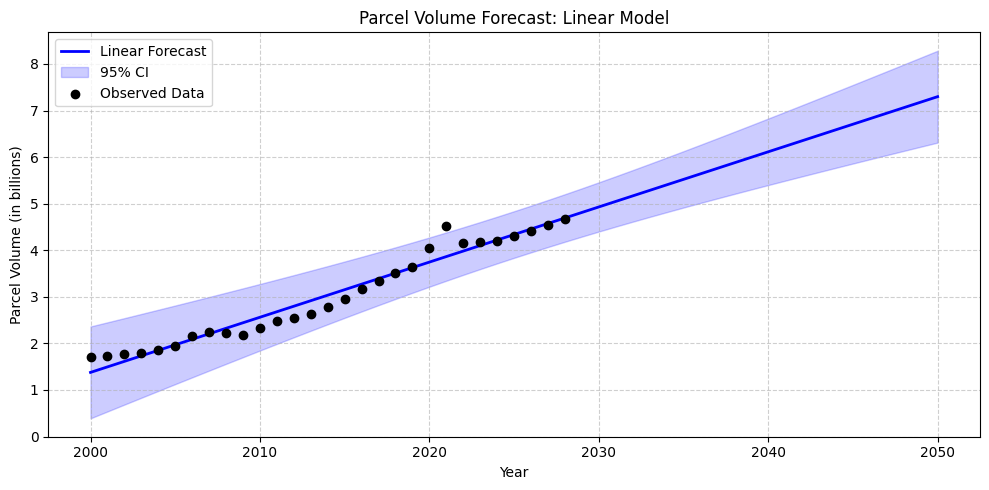

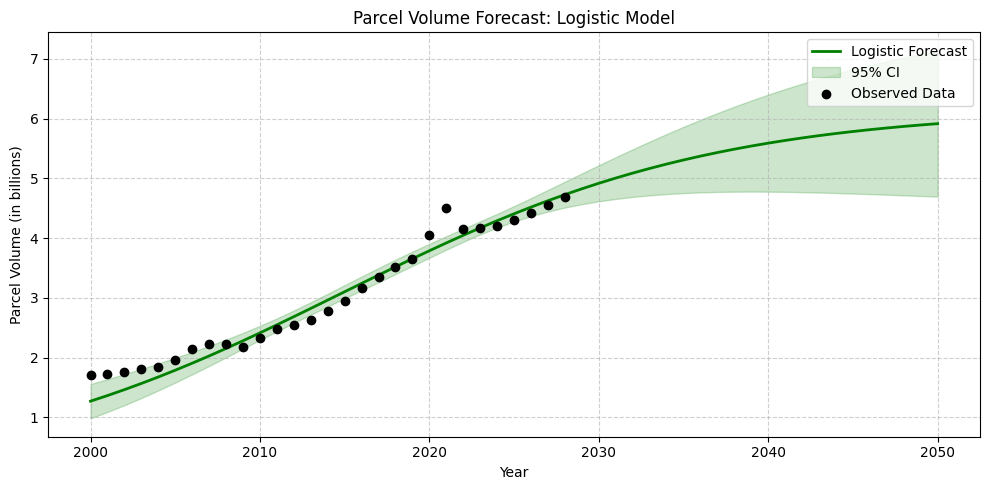

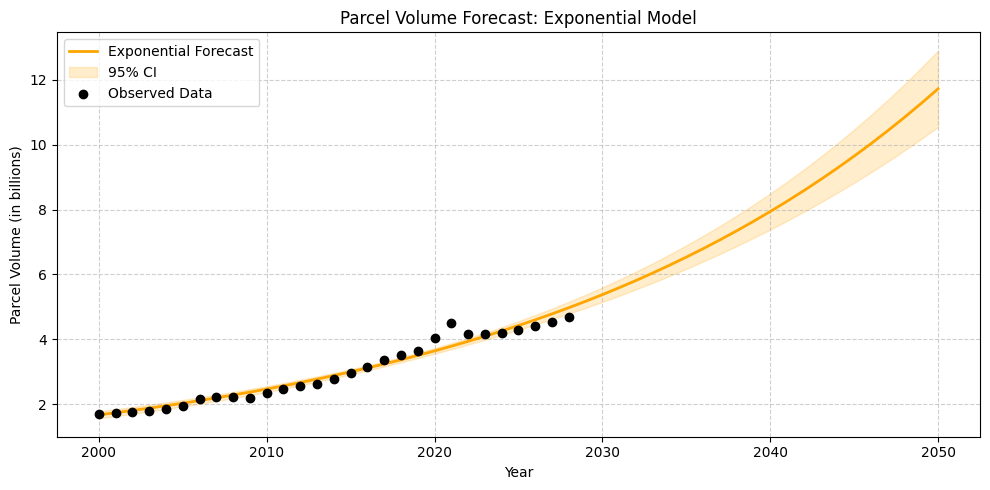

In [13]:
# === Extract Observed Parcel Volume Data ===
x_obs = df_parcel_volumes["Year"]             # Observed years
y_obs = df_parcel_volumes["Parcel_Volume"]    # Observed parcel volumes (in billions)


# === PLOT 1: Linear Regression Forecast with 95% Confidence Interval ===
plt.figure(figsize=(10, 5))

# Plot the model forecast
plt.plot(years, y_future_linear, label="Linear Forecast", color="blue", linewidth=2)

# Plot the confidence interval as shaded area
plt.fill_between(years, ci_lower_linear, ci_upper_linear, color="blue", alpha=0.2, label="95% CI")

# Scatter the actual historical data
plt.scatter(x_obs, y_obs, color="black", label="Observed Data", zorder=5)

# Plot styling
plt.title("Parcel Volume Forecast: Linear Model")
plt.xlabel("Year")
plt.ylabel("Parcel Volume (in billions)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# === PLOT 2: Logistic Model Forecast with 95% Confidence Interval ===
plt.figure(figsize=(10, 5))

# Plot the model forecast
plt.plot(years, y_future_log, label="Logistic Forecast", color="green", linewidth=2)

# Confidence interval (shaded)
plt.fill_between(years, ci_lower_logistic, ci_upper_logistic, color="green", alpha=0.2, label="95% CI")

# Observed data
plt.scatter(x_obs, y_obs, color="black", label="Observed Data", zorder=5)

# Plot styling
plt.title("Parcel Volume Forecast: Logistic Model")
plt.xlabel("Year")
plt.ylabel("Parcel Volume (in billions)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# === PLOT 3: Exponential Model Forecast with 95% Confidence Interval ===
plt.figure(figsize=(10, 5))

# Forecast curve
plt.plot(years, y_future_exp, label="Exponential Forecast", color="orange", linewidth=2)

# CI shading
plt.fill_between(years, ci_lower_exp, ci_upper_exp, color="orange", alpha=0.2, label="95% CI")

# Observed data points
plt.scatter(x_obs, y_obs, color="black", label="Observed Data", zorder=5)

# Final touches
plt.title("Parcel Volume Forecast: Exponential Model")
plt.xlabel("Year")
plt.ylabel("Parcel Volume (in billions)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
forecast_df

,year,linear,ci_lower_linear,ci_upper_linear,logistic,ci_lower_logistic,ci_upper_logistic,exponential,ci_lower_exponential,ci_upper_exponential,weeks_in_year
0,2000,1.377014,0.390730,2.363298,1.270573,0.983727,1.557419,1.670409,1.562900,1.777918,52
1,2001,1.495434,0.538290,2.452578,1.364583,1.090217,1.638949,1.736801,1.630096,1.843507,52
2,2002,1.613854,0.685520,2.542188,1.463466,1.203558,1.723373,1.805833,1.700123,1.911544,52
3,2003,1.732274,0.832388,2.632161,1.567170,1.323522,1.810818,1.877609,1.773090,1.982127,52
4,2004,1.850695,0.978858,2.722531,1.675600,1.449745,1.901454,1.952237,1.849110,2.055364,53
5,2005,1.969115,1.124892,2.813338,1.788608,1.581705,1.995510,2.029831,1.928297,2.131365,52
6,2006,2.087535,1.270444,2.904626,1.905995,1.718700,2.093290,2.110510,2.010767,2.210254,52
7,2007,2.205955,1.415464,2.996446,2.027511,1.859823,2.195199,2.194395,2.096632,2.292159,52
8,2008,2.324375,1.559899,3.088852,2.152850,2.003925,2.301775,2.281615,2.186006,2.377223,52
9,2009,2.442796,1.703685,3.181906,2.281656,2.149609,2.413704,2.372301,2.278998,2.465604,53


In [40]:
# Export the DataFrame to a CSV file
forecast_df.to_csv("output/02_parcel_volumen_estimation_complete.csv", index=False)
model_predictions_df.to_csv("output/02_forecast_only_model_predictions.csv", index=False)
